In [1]:
import sys
import os
sys.path.append('../CGH_Toolbox/')
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
import numpy as np
import nglview as nv
import MDAnalysis as mda
import pyvibdmc as pv
import utilities as uts
import gaussian_tools as gt
import misc
import glob
import pandas as pd
import pickle
from scipy import interpolate
import dvr, utilities, dvr_arrays
from McUtils import Data as McData
import copy

# Outstanding questions:

## What is the overall goal? Why am I doing this?

## Why HOONO?

# 2nd-Derivative of potential v coordinate displacement

- I can generate a series of SP calculations that change the energy by 10, 15, 20, 25 wavenumbers, etc. 
- I then need to pull the input geometry and energy from each scan
- From there I can figure out which coordinate was changed, by how much, and how much the energy actually changed.
- From there I need to calculate the 2nd derivative of the potential with finite difference and compare it to the 2nd derivative from gaussian

What pieces do I still need?
- I need to be able to calculate derivatives

How should I pull the information from gaussian?
```
results = {'filenames': []
             'disp_coords':[]
             'disp_vals': []
             'coord_units': []
             'disp_energys: []
             }
             

            

In [2]:
hoono_eq_energy = -280.4467347

In [3]:
atoms = ['H', 'O', 'O', 'N', 'O']
specs = np.array([[1, 2, 3, 4], [1, 2, 3], [1, 2]])
names = np.array([['r1', 'r2', 'r3', 'r4'], ['a1', 'a2', 'a3'], ['d1', 'd2']])
vals = np.array([[0.96897556, 1.45491931, 1.45878406, 1.17072885],
                 [97.59494903, 102.29752444, 109.06955123],
                 [180., 180.]])
units = ["Angstroms", "Degrees"]
hoono_eq = misc.zmat(atoms=atoms, easy_build_dict={'specs':specs, 'names':names, 'vals':vals, 'units':units})

<ipython-input-3-eb58ad143722>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  specs = np.array([[1, 2, 3, 4], [1, 2, 3], [1, 2]])
<ipython-input-3-eb58ad143722>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  names = np.array([['r1', 'r2', 'r3', 'r4'], ['a1', 'a2', 'a3'], ['d1', 'd2']])
<ipython-input-3-eb58ad143722>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

In [4]:
hoono_eq_log = gt.GLogInterpreter(log_files='../mccoy_hoono/hoono_eq.log')
hoono_eq_log.pull_forces()

In [5]:
forces = misc.convert_force_units(eq_zmat=hoono_eq, force_constants=hoono_eq_log.force_constants)

In [6]:
for i in range(len(forces)):
    print(forces[i][i])

401567.88622114423
220493.89272176367
91863.50739534566
636473.5235528407
14.49119433185497
18.902206034701653
32.26975500462167
-0.5193839588368713
2.7477397841878695


## 20 cm displacements

In [8]:
params = {
                'header': f'%nproc=28\n%mem=120GB\n%chk=',
                'job': '#p SP Freq mp2/aug-cc-pvtz density=current\n\n',
                'description': 'title\n\n',
                'charge': '0 1\n',
                'molecule': '',
                'variables': 'Variables\n',
                'vars': '',
                'whitespace': '\n'*10}

In [11]:
misc.write_displaced_zmats(eq_zmat=hoono_eq,
                           disp_en=20,
                           force_constants=hoono_eq_log.force_constants,
                           fname_base='hoono',
                           fchks=True,
                           params=params,
                           job_file_path='../mccoy_hoono/20cm_disp/')

In [7]:
files=['../mccoy_hoono/20cm_disp/hoono_r3_1p437917',
       '../mccoy_hoono/20cm_disp/hoono_a2_100p8428',
       '../mccoy_hoono/20cm_disp/hoono_d1_188p7757',
       '../mccoy_hoono/20cm_disp/hoono_a3_110p1829',
       '../mccoy_hoono/20cm_disp/hoono_r4_1p162801',
       '../mccoy_hoono/20cm_disp/hoono_r4_1p178656',
       '../mccoy_hoono/20cm_disp/hoono_a1_99p25636',
       '../mccoy_hoono/20cm_disp/hoono_d1_171p2242',
       '../mccoy_hoono/20cm_disp/hoono_a2_103p7522',
       '../mccoy_hoono/20cm_disp/hoono_r1_0p958995',
       '../mccoy_hoono/20cm_disp/hoono_r1_0p978956',
       '../mccoy_hoono/20cm_disp/hoono_a3_107p9562',
       '../mccoy_hoono/20cm_disp/hoono_r3_1p479650',
       '../mccoy_hoono/20cm_disp/hoono_a1_95p93353',
       '../mccoy_hoono/20cm_disp/hoono_r2_1p441450',
       '../mccoy_hoono/20cm_disp/hoono_r2_1p468388']

In [9]:
hoono_eq_energy = -280.4467347

In [10]:
results = misc.pull_displaced_results(eq_zmat=hoono_eq,
                                          eq_energy=hoono_eq_energy,
                                          files=files,
                                          sec_der=True)

In [11]:
results

{'r3': {'filenames': ['../mccoy_hoono/explore_disps/hoono_r3_1p437917',
   '../mccoy_hoono/explore_disps/hoono_r3_1p479650'],
  'disp_vals': [-0.02086405999999985, 0.02086593999999997],
  'disp_units': ['Angstroms', 'Angstroms'],
  'disp_energies': [20.33404849615159, 19.738964185233865],
  '2nd_der': 92056.47645813132},
 'a2': {'filenames': ['../mccoy_hoono/explore_disps/hoono_a2_100p8428',
   '../mccoy_hoono/explore_disps/hoono_a2_103p7522'],
  'disp_vals': [-1.4547044400000004, 1.4547055599999936],
  'disp_units': ['Degrees', 'Degrees'],
  'disp_energies': [20.15277258929681, 19.84383383634404],
  '2nd_der': 18.90051403319394},
 'd1': {'filenames': ['../mccoy_hoono/explore_disps/hoono_d1_188p7757',
   '../mccoy_hoono/explore_disps/hoono_d1_171p2242'],
  'disp_vals': [8.775779999999997, -8.775779999999997],
  'disp_units': ['Degrees', 'Degrees'],
  'disp_energies': [-19.81224284827506, -19.81224278589662],
  '2nd_der': -0.5145080604255593},
 'a3': {'filenames': ['../mccoy_hoono/explo

## 10 cm-1 displacements

In [14]:
params = {
                'header': f'%nproc=28\n%mem=120GB\n%chk=',
                'job': '#p SP mp2/aug-cc-pvtz density=current\n\n',
                'description': 'title\n\n',
                'charge': '0 1\n',
                'molecule': '',
                'variables': 'Variables\n',
                'vars': '',
                'whitespace': '\n'*10}

In [15]:
misc.write_displaced_zmats(eq_zmat=hoono_eq,
                           disp_en=10,
                           force_constants=hoono_eq_log.force_constants,
                           fname_base='hoono',
                           params=params,
                           job_file_path='../mccoy_hoono/10cm_disp/')

In [ ]:
[os.path.splitext(val)[0] for val in glob.glob("../mccoy_hoono/10cm_disp/*.gjf")]

In [19]:
files_10_cm = ['../mccoy_hoono/10cm_disp/hoono_r4_1p165123',
         '../mccoy_hoono/10cm_disp/hoono_r1_0p976032',
         '../mccoy_hoono/10cm_disp/hoono_a2_103p3261',
         '../mccoy_hoono/10cm_disp/hoono_a2_101p2688',
         '../mccoy_hoono/10cm_disp/hoono_r2_1p464443',
         '../mccoy_hoono/10cm_disp/hoono_r3_1p473539',
         '../mccoy_hoono/10cm_disp/hoono_r1_0p961918',
         '../mccoy_hoono/10cm_disp/hoono_a3_109p8568',
         '../mccoy_hoono/10cm_disp/hoono_d1_186p2054',
         '../mccoy_hoono/10cm_disp/hoono_d1_173p7945',
         '../mccoy_hoono/10cm_disp/hoono_a1_96p42015',
         '../mccoy_hoono/10cm_disp/hoono_r4_1p176334',
         '../mccoy_hoono/10cm_disp/hoono_r3_1p444028',
         '../mccoy_hoono/10cm_disp/hoono_a1_98p76974',
         '../mccoy_hoono/10cm_disp/hoono_r2_1p445395',
         '../mccoy_hoono/10cm_disp/hoono_a3_108p2822']

In [20]:
results_10_cm = misc.pull_displaced_results(eq_zmat=hoono_eq,
                                          eq_energy=hoono_eq_energy,
                                          files=files_10_cm,
                                          sec_der=True)

In [21]:
results_10_cm

{'r4': {'filenames': ['../mccoy_hoono/10cm_disp/hoono_r4_1p165123',
   '../mccoy_hoono/10cm_disp/hoono_r4_1p176334'],
  'disp_vals': [-0.0056088499999999986, 0.005601150000000166],
  'disp_units': ['Angstroms', 'Angstroms'],
  'disp_energies': [11.024968119803177, 8.952491230579763],
  '2nd_der': 635027.6045049384},
 'r1': {'filenames': ['../mccoy_hoono/10cm_disp/hoono_r1_0p976032',
   '../mccoy_hoono/10cm_disp/hoono_r1_0p961918'],
  'disp_vals': [0.007054439999999995, -0.007055559999999961],
  'disp_units': ['Angstroms', 'Angstroms'],
  'disp_energies': [9.834038867721675, 10.14416348475961],
  '2nd_der': 401449.86813368637},
 'a2': {'filenames': ['../mccoy_hoono/10cm_disp/hoono_a2_103p3261',
   '../mccoy_hoono/10cm_disp/hoono_a2_101p2688'],
  'disp_vals': [1.0286255599999947, -1.0286244400000015],
  'disp_units': ['Degrees', 'Degrees'],
  'disp_energies': [10.04520805849229, 9.934914190152544],
  '2nd_der': 18.8835445677722},
 'r2': {'filenames': ['../mccoy_hoono/10cm_disp/hoono_r2_1

## 30 cm-1 displacements

In [22]:
params = {
                'header': f'%nproc=28\n%mem=120GB\n%chk=',
                'job': '#p SP mp2/aug-cc-pvtz density=current\n\n',
                'description': 'title\n\n',
                'charge': '0 1\n',
                'molecule': '',
                'variables': 'Variables\n',
                'vars': '',
                'whitespace': '\n'*10}

In [23]:
misc.write_displaced_zmats(eq_zmat=hoono_eq,
                           disp_en=30,
                           force_constants=hoono_eq_log.force_constants,
                           fname_base='hoono',
                           params=params,
                           job_file_path='../mccoy_hoono/30cm_disp/')

In [ ]:
[os.path.splitext(val)[0] for val in glob.glob("../mccoy_hoono/30cm_disp/*.gjf")]

In [25]:
files_30_cm = ['../mccoy_hoono/30cm_disp/hoono_a1_95p56014',
             '../mccoy_hoono/30cm_disp/hoono_r3_1p433227',
             '../mccoy_hoono/30cm_disp/hoono_r2_1p471415',
             '../mccoy_hoono/30cm_disp/hoono_r4_1p161019',
             '../mccoy_hoono/30cm_disp/hoono_r1_0p956752',
             '../mccoy_hoono/30cm_disp/hoono_a2_104p0791',
             '../mccoy_hoono/30cm_disp/hoono_d1_169p2519',
             '../mccoy_hoono/30cm_disp/hoono_a3_107p7059',
             '../mccoy_hoono/30cm_disp/hoono_d1_190p7480',
             '../mccoy_hoono/30cm_disp/hoono_r3_1p484340',
             '../mccoy_hoono/30cm_disp/hoono_a1_99p62975',
             '../mccoy_hoono/30cm_disp/hoono_r1_0p981199',
             '../mccoy_hoono/30cm_disp/hoono_a2_100p5158',
             '../mccoy_hoono/30cm_disp/hoono_a3_110p4331',
             '../mccoy_hoono/30cm_disp/hoono_r4_1p180438',
             '../mccoy_hoono/30cm_disp/hoono_r2_1p438423']

In [26]:
results_30_cm = misc.pull_displaced_results(eq_zmat=hoono_eq,
                                          eq_energy=hoono_eq_energy,
                                          files=files_30_cm,
                                          sec_der=True)

In [27]:
results_30_cm

{'a1': {'filenames': ['../mccoy_hoono/30cm_disp/hoono_a1_95p56014',
   '../mccoy_hoono/30cm_disp/hoono_a1_99p62975'],
  'disp_vals': [-2.034809029999991, 2.0348109700000094],
  'disp_units': ['Degrees', 'Degrees'],
  'disp_energies': [29.30239909629045, 30.672280471126925],
  '2nd_der': 14.485070849821826},
 'r3': {'filenames': ['../mccoy_hoono/30cm_disp/hoono_r3_1p433227',
   '../mccoy_hoono/30cm_disp/hoono_r3_1p484340'],
  'disp_vals': [-0.025554059999999934, 0.025555940000000055],
  'disp_units': ['Angstroms', 'Angstroms'],
  'disp_energies': [31.12145520617967, 29.074596718912044],
  '2nd_der': 92182.43754275811},
 'r2': {'filenames': ['../mccoy_hoono/30cm_disp/hoono_r2_1p471415',
   '../mccoy_hoono/30cm_disp/hoono_r2_1p438423'],
  'disp_vals': [0.016500689999999985, -0.016499309999999934],
  'disp_units': ['Angstroms', 'Angstroms'],
  'disp_energies': [30.73116987477869, 29.2812280901139],
  '2nd_der': 220412.77892003},
 'r4': {'filenames': ['../mccoy_hoono/30cm_disp/hoono_r4_1p16

## 5 cm-1 displacements

In [8]:
sbatch_params = '#SBATCH --job-name=hoono\n#SBATCH --ntasks=28\n#SBATCH --nodes=1 \n#SBATCH --time=3:00:00\n#SBATCH --mem=120G\n#SBATCH --chdir=/gscratch/ilahie/mccoygrp/coire_hoono/5cm_disp/\n#SBATCH --partition=ilahie\n#SBATCH --account=ilahie\n'

In [9]:
misc.write_displaced_zmats(eq_zmat=hoono_eq,
                           disp_en=5,
                           force_constants=hoono_eq_log.force_constants,
                           fname_base='hoono',
                           sbatch_params = sbatch_params,
                           fchks=True,
                           params=params,
                           job_file_path='../mccoy_hoono/5cm_disp/')

## 15 cm-1 displacements

In [11]:
sbatch_params = '#SBATCH --job-name=hoono\n#SBATCH --ntasks=28\n#SBATCH --nodes=1 \n#SBATCH --time=3:00:00\n#SBATCH --mem=120G\n#SBATCH --chdir=/gscratch/ilahie/mccoygrp/coire_hoono/15cm_disp/\n#SBATCH --partition=ilahie\n#SBATCH --account=ilahie\n'

In [12]:
misc.write_displaced_zmats(eq_zmat=hoono_eq,
                           disp_en=15,
                           force_constants=hoono_eq_log.force_constants,
                           fname_base='hoono',
                           sbatch_params = sbatch_params,
                           fchks=True,
                           params=params,
                           job_file_path='../mccoy_hoono/15cm_disp/')

## 25 cm-1 displacements

In [13]:
sbatch_params = '#SBATCH --job-name=hoono\n#SBATCH --ntasks=28\n#SBATCH --nodes=1 \n#SBATCH --time=3:00:00\n#SBATCH --mem=120G\n#SBATCH --chdir=/gscratch/ilahie/mccoygrp/coire_hoono/25cm_disp/\n#SBATCH --partition=ilahie\n#SBATCH --account=ilahie\n'

In [14]:
misc.write_displaced_zmats(eq_zmat=hoono_eq,
                           disp_en=25,
                           force_constants=hoono_eq_log.force_constants,
                           fname_base='hoono',
                           sbatch_params = sbatch_params,
                           fchks=True,
                           params=params,
                           job_file_path='../mccoy_hoono/25cm_disp/')

## 35 cm-1 displacements

In [15]:
sbatch_params = '#SBATCH --job-name=hoono\n#SBATCH --ntasks=28\n#SBATCH --nodes=1 \n#SBATCH --time=3:00:00\n#SBATCH --mem=120G\n#SBATCH --chdir=/gscratch/ilahie/mccoygrp/coire_hoono/35cm_disp/\n#SBATCH --partition=ilahie\n#SBATCH --account=ilahie\n'

In [16]:
misc.write_displaced_zmats(eq_zmat=hoono_eq,
                           disp_en=35,
                           force_constants=hoono_eq_log.force_constants,
                           fname_base='hoono',
                           sbatch_params = sbatch_params,
                           fchks=True,
                           params=params,
                           job_file_path='../mccoy_hoono/35cm_disp/')

## 40cm-1 displacements

In [17]:
sbatch_params = '#SBATCH --job-name=hoono\n#SBATCH --ntasks=28\n#SBATCH --nodes=1 \n#SBATCH --time=3:00:00\n#SBATCH --mem=120G\n#SBATCH --chdir=/gscratch/ilahie/mccoygrp/coire_hoono/40cm_disp/\n#SBATCH --partition=ilahie\n#SBATCH --account=ilahie\n'

In [18]:
misc.write_displaced_zmats(eq_zmat=hoono_eq,
                           disp_en=40,
                           force_constants=hoono_eq_log.force_constants,
                           fname_base='hoono',
                           sbatch_params = sbatch_params,
                           fchks=True,
                           params=params,
                           job_file_path='../mccoy_hoono/40cm_disp/')

## 45 cm-1 displacements

In [19]:
sbatch_params = '#SBATCH --job-name=hoono\n#SBATCH --ntasks=28\n#SBATCH --nodes=1 \n#SBATCH --time=3:00:00\n#SBATCH --mem=120G\n#SBATCH --chdir=/gscratch/ilahie/mccoygrp/coire_hoono/45cm_disp/\n#SBATCH --partition=ilahie\n#SBATCH --account=ilahie\n'

In [20]:
misc.write_displaced_zmats(eq_zmat=hoono_eq,
                           disp_en=45,
                           force_constants=hoono_eq_log.force_constants,
                           fname_base='hoono',
                           sbatch_params = sbatch_params,
                           fchks=True,
                           params=params,
                           job_file_path='../mccoy_hoono/45cm_disp/')

## 50 cm-1 displacements

In [21]:
sbatch_params = '#SBATCH --job-name=hoono\n#SBATCH --ntasks=28\n#SBATCH --nodes=1 \n#SBATCH --time=3:00:00\n#SBATCH --mem=120G\n#SBATCH --chdir=/gscratch/ilahie/mccoygrp/coire_hoono/50cm_disp/\n#SBATCH --partition=ilahie\n#SBATCH --account=ilahie\n'

In [22]:
misc.write_displaced_zmats(eq_zmat=hoono_eq,
                           disp_en=50,
                           force_constants=hoono_eq_log.force_constants,
                           fname_base='hoono',
                           sbatch_params = sbatch_params,
                           fchks=True,
                           params=params,
                           job_file_path='../mccoy_hoono/50cm_disp/')

## Combined Results

In [ ]:
files=['../mccoy_hoono/explore_disps/hoono_r3_1p437917',
       '../mccoy_hoono/explore_disps/hoono_a2_100p8428',
       '../mccoy_hoono/explore_disps/hoono_d1_188p7757',
       '../mccoy_hoono/explore_disps/hoono_a3_110p1829',
       '../mccoy_hoono/explore_disps/hoono_r4_1p162801',
       '../mccoy_hoono/explore_disps/hoono_r4_1p178656',
       '../mccoy_hoono/explore_disps/hoono_a1_99p25636',
       '../mccoy_hoono/explore_disps/hoono_d1_171p2242',
       '../mccoy_hoono/explore_disps/hoono_a2_103p7522',
       '../mccoy_hoono/explore_disps/hoono_r1_0p958995',
       '../mccoy_hoono/explore_disps/hoono_r1_0p978956',
       '../mccoy_hoono/explore_disps/hoono_a3_107p9562',
       '../mccoy_hoono/explore_disps/hoono_r3_1p479650',
       '../mccoy_hoono/explore_disps/hoono_a1_95p93353',
       '../mccoy_hoono/explore_disps/hoono_r2_1p441450',
       '../mccoy_hoono/explore_disps/hoono_r2_1p468388',
       '../mccoy_hoono/10cm_disp/hoono_r4_1p165123',
         '../mccoy_hoono/10cm_disp/hoono_r1_0p976032',
         '../mccoy_hoono/10cm_disp/hoono_a2_103p3261',
         '../mccoy_hoono/10cm_disp/hoono_a2_101p2688',
         '../mccoy_hoono/10cm_disp/hoono_r2_1p464443',
         '../mccoy_hoono/10cm_disp/hoono_r3_1p473539',
         '../mccoy_hoono/10cm_disp/hoono_r1_0p961918',
         '../mccoy_hoono/10cm_disp/hoono_a3_109p8568',
         '../mccoy_hoono/10cm_disp/hoono_d1_186p2054',
         '../mccoy_hoono/10cm_disp/hoono_d1_173p7945',
         '../mccoy_hoono/10cm_disp/hoono_a1_96p42015',
         '../mccoy_hoono/10cm_disp/hoono_r4_1p176334',
         '../mccoy_hoono/10cm_disp/hoono_r3_1p444028',
         '../mccoy_hoono/10cm_disp/hoono_a1_98p76974',
         '../mccoy_hoono/10cm_disp/hoono_r2_1p445395',
         '../mccoy_hoono/10cm_disp/hoono_a3_108p2822',
      ]

In [ ]:
[os.path.splitext(val)[0] for val in glob.glob("../mccoy_hoono/*/*.gjf")]

In [7]:
files = ['../mccoy_hoono/30cm_disp/hoono_a1_95p56014',
         '../mccoy_hoono/30cm_disp/hoono_r3_1p433227',
         '../mccoy_hoono/30cm_disp/hoono_r2_1p471415',
         '../mccoy_hoono/30cm_disp/hoono_r4_1p161019',
         '../mccoy_hoono/30cm_disp/hoono_r1_0p956752',
         '../mccoy_hoono/30cm_disp/hoono_a2_104p0791',
         '../mccoy_hoono/30cm_disp/hoono_d1_169p2519',
         '../mccoy_hoono/30cm_disp/hoono_a3_107p7059',
         '../mccoy_hoono/30cm_disp/hoono_d1_190p7480',
         '../mccoy_hoono/30cm_disp/hoono_r3_1p484340',
         '../mccoy_hoono/30cm_disp/hoono_a1_99p62975',
         '../mccoy_hoono/30cm_disp/hoono_r1_0p981199',
         '../mccoy_hoono/30cm_disp/hoono_a2_100p5158',
         '../mccoy_hoono/30cm_disp/hoono_a3_110p4331',
         '../mccoy_hoono/30cm_disp/hoono_r4_1p180438',
         '../mccoy_hoono/30cm_disp/hoono_r2_1p438423',
         '../mccoy_hoono/5cm_disp/hoono_r1_0p963985',
         '../mccoy_hoono/5cm_disp/hoono_d1_175p6121',
         '../mccoy_hoono/5cm_disp/hoono_r4_1p166765',
         '../mccoy_hoono/5cm_disp/hoono_r3_1p448350',
         '../mccoy_hoono/5cm_disp/hoono_a1_98p42565',
         '../mccoy_hoono/5cm_disp/hoono_a3_108p5128',
         '../mccoy_hoono/5cm_disp/hoono_r3_1p469217',
         '../mccoy_hoono/5cm_disp/hoono_r2_1p448184',
         '../mccoy_hoono/5cm_disp/hoono_a1_96p76424',
         '../mccoy_hoono/5cm_disp/hoono_r2_1p461653',
         '../mccoy_hoono/5cm_disp/hoono_a2_103p0248',
         '../mccoy_hoono/5cm_disp/hoono_r4_1p174692',
         '../mccoy_hoono/5cm_disp/hoono_d1_184p3878',
         '../mccoy_hoono/5cm_disp/hoono_a2_101p5701',
         '../mccoy_hoono/5cm_disp/hoono_r1_0p973965',
         '../mccoy_hoono/5cm_disp/hoono_a3_109p6262',
         '../mccoy_hoono/45cm_disp/hoono_r3_1p427483',
         '../mccoy_hoono/45cm_disp/hoono_a1_95p10282',
         '../mccoy_hoono/45cm_disp/hoono_a3_110p7395',
         '../mccoy_hoono/45cm_disp/hoono_a1_100p0870',
         '../mccoy_hoono/45cm_disp/hoono_r4_1p182620',
         '../mccoy_hoono/45cm_disp/hoono_a2_100p1154',
         '../mccoy_hoono/45cm_disp/hoono_a2_104p4795',
         '../mccoy_hoono/45cm_disp/hoono_d1_193p1636',
         '../mccoy_hoono/45cm_disp/hoono_r4_1p158837',
         '../mccoy_hoono/45cm_disp/hoono_r2_1p434715',
         '../mccoy_hoono/45cm_disp/hoono_d1_166p8363',
         '../mccoy_hoono/45cm_disp/hoono_a3_107p3995',
         '../mccoy_hoono/45cm_disp/hoono_r1_0p954004',
         '../mccoy_hoono/45cm_disp/hoono_r1_0p983946',
         '../mccoy_hoono/45cm_disp/hoono_r3_1p490084',
         '../mccoy_hoono/45cm_disp/hoono_r2_1p475122',
         '../mccoy_hoono/explore_disps/hoono_r3_1p437917',
         '../mccoy_hoono/explore_disps/hoono_a2_100p8428',
         '../mccoy_hoono/explore_disps/hoono_d1_188p7757',
         '../mccoy_hoono/explore_disps/hoono_a3_110p1829',
         '../mccoy_hoono/explore_disps/hoono_r4_1p162801',
         '../mccoy_hoono/explore_disps/hoono_a1_99p25636',
         '../mccoy_hoono/explore_disps/hoono_d1_171p2242',
         '../mccoy_hoono/explore_disps/hoono_a2_103p7522',
         '../mccoy_hoono/explore_disps/hoono_r1_0p958995',
         '../mccoy_hoono/explore_disps/hoono_r1_0p978956',
         '../mccoy_hoono/explore_disps/hoono_a3_107p9562',
         '../mccoy_hoono/explore_disps/hoono_r3_1p479650',
         '../mccoy_hoono/explore_disps/hoono_a1_95p93353',
         '../mccoy_hoono/explore_disps/hoono_r2_1p441450',
         '../mccoy_hoono/explore_disps/hoono_r2_1p468388',
         '../mccoy_hoono/10cm_disp/hoono_r4_1p165123',
         '../mccoy_hoono/10cm_disp/hoono_r1_0p976032',
         '../mccoy_hoono/10cm_disp/hoono_a2_103p3261',
         '../mccoy_hoono/10cm_disp/hoono_a2_101p2688',
         '../mccoy_hoono/10cm_disp/hoono_r2_1p464443',
         '../mccoy_hoono/10cm_disp/hoono_r3_1p473539',
         '../mccoy_hoono/10cm_disp/hoono_r1_0p961918',
         '../mccoy_hoono/10cm_disp/hoono_a3_109p8568',
         '../mccoy_hoono/10cm_disp/hoono_d1_186p2054',
         '../mccoy_hoono/10cm_disp/hoono_d1_173p7945',
         '../mccoy_hoono/10cm_disp/hoono_a1_96p42015',
         '../mccoy_hoono/10cm_disp/hoono_r4_1p176334',
         '../mccoy_hoono/10cm_disp/hoono_r3_1p444028',
         '../mccoy_hoono/10cm_disp/hoono_a1_98p76974',
         '../mccoy_hoono/10cm_disp/hoono_r2_1p445395',
         '../mccoy_hoono/10cm_disp/hoono_a3_108p2822',
         '../mccoy_hoono/40cm_disp/hoono_a1_95p24535',
         '../mccoy_hoono/40cm_disp/hoono_r1_0p983090',
         '../mccoy_hoono/40cm_disp/hoono_r2_1p435871',
         '../mccoy_hoono/40cm_disp/hoono_a1_99p94454',
         '../mccoy_hoono/40cm_disp/hoono_r1_0p954861',
         '../mccoy_hoono/40cm_disp/hoono_a2_100p2402',
         '../mccoy_hoono/40cm_disp/hoono_r4_1p181940',
         '../mccoy_hoono/40cm_disp/hoono_a3_107p4950',
         '../mccoy_hoono/40cm_disp/hoono_d1_167p5891',
         '../mccoy_hoono/40cm_disp/hoono_d1_192p4108',
         '../mccoy_hoono/40cm_disp/hoono_r4_1p159517',
         '../mccoy_hoono/40cm_disp/hoono_r3_1p488294',
         '../mccoy_hoono/40cm_disp/hoono_a2_104p3547',
         '../mccoy_hoono/40cm_disp/hoono_a3_110p6440',
         '../mccoy_hoono/40cm_disp/hoono_r2_1p473967',
         '../mccoy_hoono/40cm_disp/hoono_r3_1p429273',
         '../mccoy_hoono/15cm_disp/hoono_r2_1p466583',
         '../mccoy_hoono/15cm_disp/hoono_a2_103p5573',
         '../mccoy_hoono/15cm_disp/hoono_r1_0p960332',
         '../mccoy_hoono/15cm_disp/hoono_a1_99p03377',
         '../mccoy_hoono/15cm_disp/hoono_r4_1p163863',
         '../mccoy_hoono/15cm_disp/hoono_r4_1p177594',
         '../mccoy_hoono/15cm_disp/hoono_a2_101p0377',
         '../mccoy_hoono/15cm_disp/hoono_a3_110p0337',
         '../mccoy_hoono/15cm_disp/hoono_r3_1p440712',
         '../mccoy_hoono/15cm_disp/hoono_r3_1p476855',
         '../mccoy_hoono/15cm_disp/hoono_d1_187p6000',
         '../mccoy_hoono/15cm_disp/hoono_a1_96p15612',
         '../mccoy_hoono/15cm_disp/hoono_r1_0p977618',
         '../mccoy_hoono/15cm_disp/hoono_d1_172p3999',
         '../mccoy_hoono/15cm_disp/hoono_r2_1p443254',
         '../mccoy_hoono/15cm_disp/hoono_a3_108p1053',
         '../mccoy_hoono/50cm_disp/hoono_a2_99p99744',
         '../mccoy_hoono/50cm_disp/hoono_r4_1p183263',
         '../mccoy_hoono/50cm_disp/hoono_a3_110p8299',
         '../mccoy_hoono/50cm_disp/hoono_d1_166p1242',
         '../mccoy_hoono/50cm_disp/hoono_a3_107p3091',
         '../mccoy_hoono/50cm_disp/hoono_r2_1p433623',
         '../mccoy_hoono/50cm_disp/hoono_r3_1p425790',
         '../mccoy_hoono/50cm_disp/hoono_a1_100p2218',
         '../mccoy_hoono/50cm_disp/hoono_a1_94p96802',
         '../mccoy_hoono/50cm_disp/hoono_a2_104p5976',
         '../mccoy_hoono/50cm_disp/hoono_r1_0p984756',
         '../mccoy_hoono/50cm_disp/hoono_r4_1p158194',
         '../mccoy_hoono/50cm_disp/hoono_r3_1p491777',
         '../mccoy_hoono/50cm_disp/hoono_r1_0p953195',
         '../mccoy_hoono/50cm_disp/hoono_d1_193p8757',
         '../mccoy_hoono/50cm_disp/hoono_r2_1p476215',
         '../mccoy_hoono/25cm_disp/hoono_r3_1p435454',
         '../mccoy_hoono/25cm_disp/hoono_r2_1p439860',
         '../mccoy_hoono/25cm_disp/hoono_a2_103p9239',
         '../mccoy_hoono/25cm_disp/hoono_d1_189p8116',
         '../mccoy_hoono/25cm_disp/hoono_r4_1p161865',
         '../mccoy_hoono/25cm_disp/hoono_a3_110p3143',
         '../mccoy_hoono/25cm_disp/hoono_a2_100p6711',
         '../mccoy_hoono/25cm_disp/hoono_r3_1p482113',
         '../mccoy_hoono/25cm_disp/hoono_a1_95p73743',
         '../mccoy_hoono/25cm_disp/hoono_a1_99p45246',
         '../mccoy_hoono/25cm_disp/hoono_r4_1p179592',
         '../mccoy_hoono/25cm_disp/hoono_r1_0p980134',
         '../mccoy_hoono/25cm_disp/hoono_r2_1p469977',
         '../mccoy_hoono/25cm_disp/hoono_r1_0p957817',
         '../mccoy_hoono/25cm_disp/hoono_a3_107p8247',
         '../mccoy_hoono/25cm_disp/hoono_d1_170p1883',
         '../mccoy_hoono/35cm_disp/hoono_a3_110p5423',
         '../mccoy_hoono/35cm_disp/hoono_d1_191p6092',
         '../mccoy_hoono/35cm_disp/hoono_r2_1p472736',
         '../mccoy_hoono/35cm_disp/hoono_a3_107p5967',
         '../mccoy_hoono/35cm_disp/hoono_a1_99p79279',
         '../mccoy_hoono/35cm_disp/hoono_r1_0p955772',
         '../mccoy_hoono/35cm_disp/hoono_r3_1p431179',
         '../mccoy_hoono/35cm_disp/hoono_a1_95p39710',
         '../mccoy_hoono/35cm_disp/hoono_a2_100p3731',
         '../mccoy_hoono/35cm_disp/hoono_r4_1p181216',
         '../mccoy_hoono/35cm_disp/hoono_a2_104p2219',
         '../mccoy_hoono/35cm_disp/hoono_r3_1p486388',
         '../mccoy_hoono/35cm_disp/hoono_d1_168p3907',
         '../mccoy_hoono/35cm_disp/hoono_r1_0p982178',
         '../mccoy_hoono/35cm_disp/hoono_r2_1p437101',
         '../mccoy_hoono/35cm_disp/hoono_r4_1p160241']

In [8]:
results = misc.pull_displaced_results(eq_zmat=hoono_eq,
                                          eq_energy=hoono_eq_energy,
                                          files=files,
                                          sec_der=True)

In [10]:
results['r1']['disp_energies']

[51.82183638569161,
 46.550306573879595,
 41.2940064212547,
 36.05381076051458,
 30.830777979160334,
 25.626226258428296,
 20.44186156137733,
 15.280014858103762,
 10.14416348475961,
 5.040390075505437,
 4.9351481748047865,
 9.834038867721675,
 14.702631141217633,
 19.547008340567466,
 24.3706474650796,
 29.175879958926522,
 33.96441073720928,
 38.73756027669086,
 43.49638596681729,
 48.241763039508264]

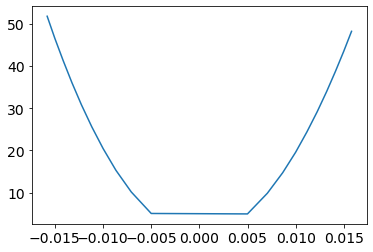

In [11]:
plt.plot(results['r1']['disp_vals'], results['r1']['disp_energies'])

- add in equilibrium structure including vals and energies

# Single-coordinate displacement frequency calculations

In [2]:
hoono_eq_energy = -280.4467347

In [3]:
atoms = ['H', 'O', 'O', 'N', 'O']
specs = np.array([[1, 2, 3, 4], [1, 2, 3], [1, 2]])
names = np.array([['r1', 'r2', 'r3', 'r4'], ['a1', 'a2', 'a3'], ['d1', 'd2']])
vals = np.array([[0.96897556, 1.45491931, 1.45878406, 1.17072885],
                 [97.59494903, 102.29752444, 109.06955123],
                 [180., 180.]])
units = ["Angstroms", "Degrees"]
hoono_eq = misc.zmat(atoms=atoms, easy_build_dict={'specs':specs, 'names':names, 'vals':vals, 'units':units})

<ipython-input-3-eb58ad143722>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  specs = np.array([[1, 2, 3, 4], [1, 2, 3], [1, 2]])
<ipython-input-3-eb58ad143722>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  names = np.array([['r1', 'r2', 'r3', 'r4'], ['a1', 'a2', 'a3'], ['d1', 'd2']])
<ipython-input-3-eb58ad143722>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

In [4]:
hoono_eq_log = gt.GLogInterpreter(log_files='../mccoy_hoono/hoono_eq.log')
hoono_eq_log.pull_forces()

In [5]:
params = {
                'header': f'%nproc=28\n%mem=120GB\n%chk=',
                'job': '#p freq mp2/aug-cc-pvtz density=current\n\n',
                'description': 'title\n\n',
                'charge': '0 1\n',
                'molecule': '',
                'variables': 'Variables\n',
                'vars': '',
                'whitespace': '\n'*10}

In [6]:
sbatch_params = '#SBATCH --job-name=hoono\n#SBATCH --ntasks=28\n#SBATCH --nodes=1 \n#SBATCH --time=3:00:00\n#SBATCH --mem=120G\n#SBATCH --chdir=/gscratch/ilahie/mccoygrp/coire_hoono/single_coord_freq/\n#SBATCH --partition=ilahie\n#SBATCH --account=ilahie\n'

In [7]:
results = misc.pull_displaced_results(eq_zmat=hoono_eq,
                                          eq_energy=hoono_eq_energy,
                                          files=[os.path.splitext(val)[0] for val in glob.glob("../mccoy_hoono/single_coord_freq/hoono_*_*.log")],
                                          eq_log='../mccoy_hoono/single_coord_freq/hoono_eq')

In [53]:
results['r1']

{'filenames': ['../mccoy_hoono/single_coord_freq/hoono_r1_0p953195',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p954004',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p954861',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p955772',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p956752',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p957817',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p958995',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p960332',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p961918',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p963985',
  'eq',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p973965',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p976032',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p977618',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p978956',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p980134',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p981199',
  '../mccoy_hoono/single_coord_freq/hoono_r1_0p982178',
  '../mccoy_hoono/single_co

In [21]:
d = misc.fourth_ders(results)

In [22]:
d['d1']

{'disp_vals': [4.387889999999999,
  6.2054100000000005,
  7.60005000000001,
  8.775779999999997,
  9.811620000000005,
  10.74808999999999,
  11.60927000000001,
  12.410830000000004,
  13.163669999999996,
  13.875730000000004],
 'fourth_ders': [0.0008141348781621635,
  0.0008145872194774277,
  0.0008135558090016095,
  0.0008123813248333546,
  0.0008106625478464312,
  0.0008088570891726416,
  0.0008070208589011251,
  0.0008051670727567681,
  0.0008032933273283977,
  0.0008014186105162231]}

In [25]:
en = np.linspace(5, 50, 10)

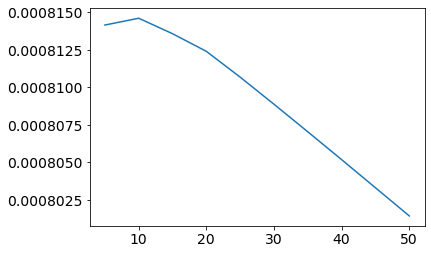

In [26]:
plt.plot(en, d['d1']['fourth_ders'])

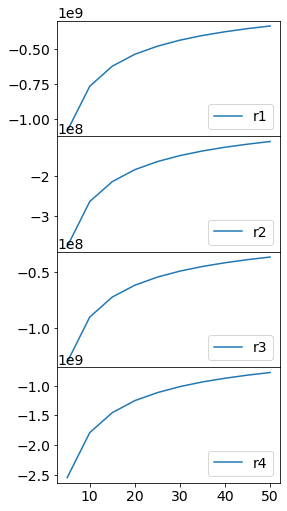

In [36]:
en = np.linspace(5, 50, 10)
fig, axs = plt.subplots(4, 1, sharex=True)

axs[0].plot(en, d['r1']['fourth_ders'], label='r1')
axs[1].plot(en, d['r2']['fourth_ders'], label='r2')
axs[2].plot(en, d['r3']['fourth_ders'], label='r3')
axs[3].plot(en, d['r4']['fourth_ders'], label='r4')
#axs[0,1].plot(en, d['a1']['fourth_ders'])
#axs[1,1].plot(en, d['a2']['fourth_ders'])
#axs[2,1].plot(en, d['a3']['fourth_ders'])
#axs[0,2].plot(en, d['d1']['fourth_ders'])
#axs[1,2].plot(en, d['d2']['fourth_ders'])
for ax in axs:
    ax.legend(loc='lower right')

fig.subplots_adjust(hspace = 0)
fig.set_size_inches(w=4,h=8.5)

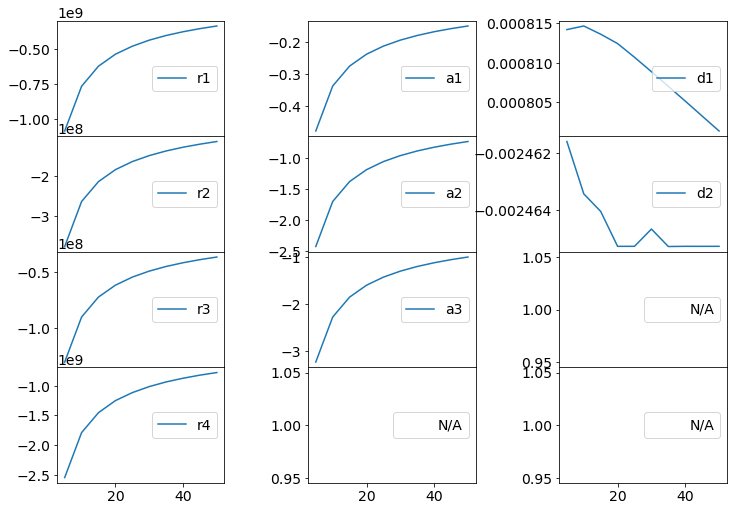

In [52]:
en = np.linspace(5, 50, 10)
fig, axs = plt.subplots(4, 3, sharex=True)

axs[0,0].plot(en, d['r1']['fourth_ders'], label='r1')
axs[1,0].plot(en, d['r2']['fourth_ders'], label='r2')
axs[2,0].plot(en, d['r3']['fourth_ders'], label='r3')
axs[3,0].plot(en, d['r4']['fourth_ders'], label='r4')
axs[0,1].plot(en, d['a1']['fourth_ders'], label='a1')
axs[1,1].plot(en, d['a2']['fourth_ders'], label='a2')
axs[2,1].plot(en, d['a3']['fourth_ders'], label='a3')
axs[0,2].plot(en, d['d1']['fourth_ders'], label='d1')
axs[1,2].plot(en, d['d2']['fourth_ders'], label='d2')

axs[3,1].plot(en, np.ones(10), color='white', label='N/A')
axs[2,2].plot(en, np.ones(10), color='white', label='N/A')
axs[3,2].plot(en, np.ones(10), color='white', label='N/A')

for ax in axs:
    for a in ax:
        a.legend(loc='center right')

fig.subplots_adjust(hspace = 0, wspace=0.5)
fig.set_size_inches(w=12,h=8.5)

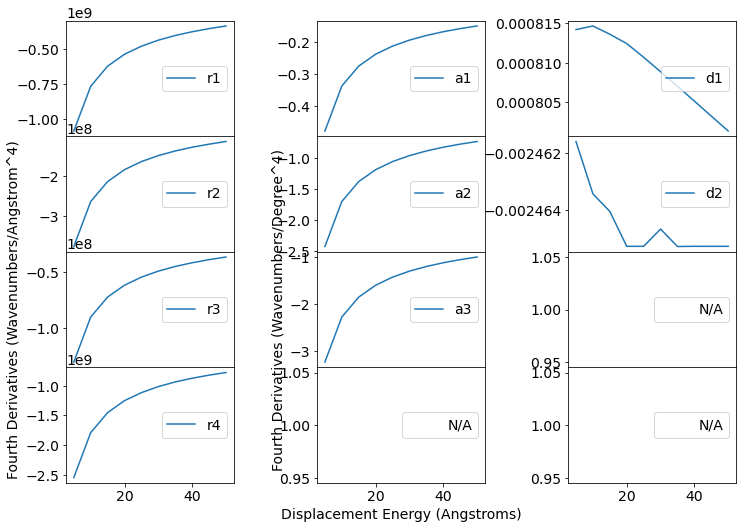

In [60]:
en = np.linspace(5, 50, 10)
fig, axs = plt.subplots(4, 3, sharex=True)

axs[0,0].plot(en, d['r1']['fourth_ders'], label='r1')
axs[1,0].plot(en, d['r2']['fourth_ders'], label='r2')
axs[2,0].plot(en, d['r3']['fourth_ders'], label='r3')
axs[3,0].plot(en, d['r4']['fourth_ders'], label='r4')
axs[0,1].plot(en, d['a1']['fourth_ders'], label='a1')
axs[1,1].plot(en, d['a2']['fourth_ders'], label='a2')
axs[2,1].plot(en, d['a3']['fourth_ders'], label='a3')
axs[0,2].plot(en, d['d1']['fourth_ders'], label='d1')
axs[1,2].plot(en, d['d2']['fourth_ders'], label='d2')

axs[3,1].plot(en, np.ones(10), color='white', label='N/A')
axs[2,2].plot(en, np.ones(10), color='white', label='N/A')
axs[3,2].plot(en, np.ones(10), color='white', label='N/A')

for ax in axs:
    for a in ax:
        a.legend(loc='center right')

axs[3,1].set_xlabel("Displacement Energy (Angstroms)")
axs[2,0].set_ylabel("Fourth Derivatives (Wavenumbers/Angstrom^4)")
axs[2,1].set_ylabel("Fourth Derivatives (Wavenumbers/Degree^4)")
fig.subplots_adjust(hspace = 0, wspace=0.5)
fig.set_size_inches(w=12,h=8.5)
plt.savefig("Validation_results.pdf")

In [54]:
d['r1']['fourth_ders']

[-1084498416.723595,
 -763833519.8036406,
 -619947050.9730767,
 -534397832.59804314,
 -476964057.1498365,
 -433603786.708519,
 -400201268.31847286,
 -373401349.8042323,
 -350939212.5777307,
 -332109028.0092983]

In [66]:
results['r1']['force_constants'][10]

401567.88622114423

In [61]:
k = 
a = np.sqrt(k/(2*D))

NameError: name 'k' is not defined

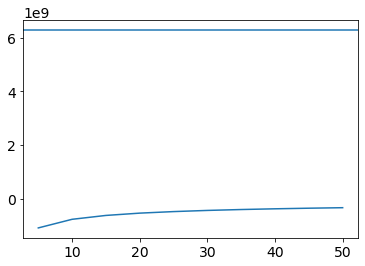

In [95]:
fig = plt.figure()
ax = plt.axes()

en = np.linspace(5, 50, 10)
k = results['r1']['force_constants'][10]
D = 90
a = np.sqrt(k/(2*D))

ax.plot(en, d['r1']['fourth_ders'], label='r1')
ax.axhline(14*a**4*D)

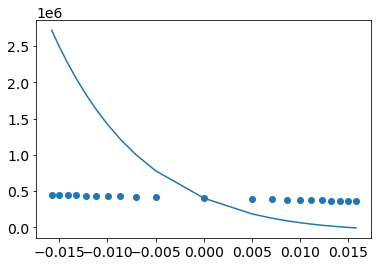

In [111]:
fig = plt.figure()
ax = plt.axes()

en = np.linspace(-50, 50, 21)

ax.scatter(results['r1']['disp_vals'], results['r1']['force_constants'], label='r1')
ax.plot(results['r1']['disp_vals'], morse_second(np.array(results['r1']['disp_vals']),results['r1']['force_constants'][10],90 ))

Plot morse 2nd derivatives as function of displacements $d \left(2 a^2 e^{-2 a (x-r)}-2 a^2 e^{-a (x-r)} \left(1-e^{-a (x-r)}\right)\right)$

In [98]:
def morse_second(x, k, d):
    a = np.sqrt(k/(2*D)) 
    return d*(2*a**2*np.exp(-2*a*(x))-2*a**2*np.exp(-a*x)*(1-np.exp(-a*x)))

In [113]:
def morse(x,r, k, D):
    a = np.sqrt(k/(2*D))
    return D*((1-np.exp(-a*(x-r)))**2)

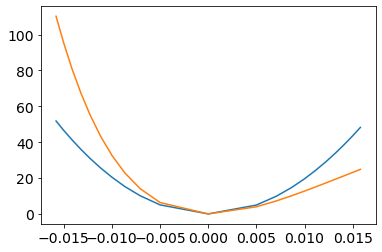

In [114]:
plt.plot(results['r1']['disp_vals'], results['r1']['disp_energies'])
plt.plot(results['r1']['disp_vals'], morse(np.array(results['r1']['disp_vals']), 0, results['r1']['force_constants'][10], 90))